In [1]:
%load_ext autoreload
%autoreload 2

### read the (decile of tercile) CDS MME probabilities, and extract a grid point 

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns 

In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [4]:
sys.path.append('../..')

In [5]:
from ICU_Water_Watch import geo, C3S, domains, plot

### year and month (initial month of the forecast)

In [6]:
year = 2021

In [7]:
month = 9

### read the probabilistic forecasts from the GCMs now 

### provider 

In [8]:
provider = 'CDS'

#### list of GCMs to inlude 

In [9]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC']
# list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP']

#### period (`monthly` or `seasonal`)

In [10]:
period = 'monthly'
# period = 'seasonal'

In [11]:
if period == 'seasonal': 
    nsteps = 3
elif period == 'monthly': 
    nsteps = 5

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [12]:
quantile = 'decile'

### variable 

In [13]:
varname = 'precip'

### domain 

In [14]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [120, 240, -38, 22.5]}

In [15]:
domain = 'Water_Watch'

### paths to the realtime forecasts

In [16]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [17]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [18]:
[f.name for f in lfiles]

['monthly_deciles_probabilities_from_2021-09_METEO_FRANCE.netcdf',
 'monthly_deciles_probabilities_from_2021-09_JMA.netcdf',
 'monthly_deciles_probabilities_from_2021-09_ECCC.netcdf',
 'monthly_deciles_probabilities_from_2021-09_UKMO.netcdf',
 'monthly_deciles_probabilities_from_2021-09_CMCC.netcdf',
 'monthly_deciles_probabilities_from_2021-09_DWD.netcdf',
 'monthly_deciles_probabilities_from_2021-09_ECMWF.netcdf',
 'monthly_deciles_probabilities_from_2021-09_NCEP.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [19]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', engine='netcdf4') 

### calculates the average across the GCM dimension 

In [20]:
probs_mean = probs.mean('GCM')

### because of numerical approximations, this average can **SOMETIMES** sum to slightly over 100 (the errors can accumulate over all the dimensions)

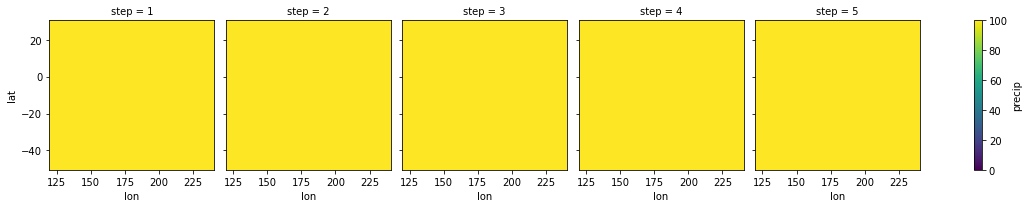

In [21]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale (just in case)

In [22]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

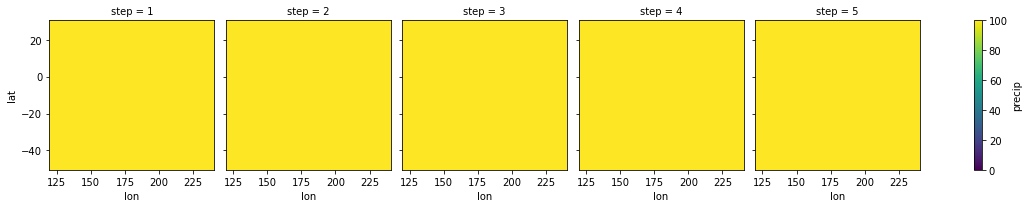

In [23]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### because the attributes are lost during these operations, we add them back 

In [24]:
probs_mean.attrs = probs.attrs

### coordinates to extract 

In [25]:
# Banaba 

# lat = -0.859444 
# lon = 169.536944

# Nadi 17.7765° S, 177.4356° E

# lat = -17.7765
# lon = 177.4356

# Tokelau 9.2002° S, 171.8484° W

# lat = -9.2002
# lon = 171.8484

# Honiara 

# lat = -9.4456
# lon = 159.9729

# Afulilo Dam (Samoa)

lat = -13.9708
lon = 171.5621

In [26]:
extract_ensmean = probs_mean.sel(lat=lat, lon=lon, method='nearest')

In [27]:
extract = probs.sel(lat=lat, lon=lon, method='nearest')

In [28]:
extract_ensmean = extract_ensmean.squeeze().load()

In [29]:
extract = extract.squeeze().load()

In [30]:
mat_ensmean = extract_ensmean['precip'].to_dataframe()['precip'].unstack()

In [31]:
mat = extract['precip'].to_dataframe()['precip'].unstack()

In [32]:
mat

step                 1          2          3          4          5
GCM  decile                                                       
CMCC 1        2.000000   2.000000  10.000000   6.000000  16.000000
     2        0.000000   8.000000   4.000000   8.000000  14.000000
     3        6.000000   0.000000   8.000000  10.000000   4.000000
     4        8.000000  10.000000  10.000000  10.000000   2.000000
     5       10.000000  10.000000   8.000000   8.000000  10.000000
...                ...        ...        ...        ...        ...
UKMO 6        9.677419  11.290323  17.741935   4.838710  11.290323
     7       17.741935  19.354839  16.129032  14.516129   9.677419
     8       14.516129  11.290323   9.677419  14.516129   8.064516
     9        9.677419  12.903226  12.903226   8.064516   6.451613
     10      16.129032   6.451613  17.741935  19.354839  22.580645

[80 rows x 5 columns]

In [33]:
mat_ensmean

step,1,2,3,4,5
decile,,,,,
1,1.750389,3.922201,5.696456,4.907495,10.883740
2,2.967097,7.690459,8.519754,9.378357,8.437193
3,8.058489,6.494526,8.373334,6.197866,6.187193
4,9.503838,12.271286,10.802839,10.916715,9.128746
5,11.829222,9.298192,9.300066,10.963363,8.900750
6,12.035238,12.034131,9.087049,10.310739,10.149236
7,19.192892,13.968654,17.016293,13.144352,9.578237
8,14.244155,11.849608,10.318190,8.355137,11.117836
9,10.227546,13.840060,9.644863,13.738761,10.353999


In [34]:
mat_clim = mat_ensmean.copy()

In [35]:
mat_clim = np.ones((10,5)) * 10.

In [36]:
mat_clim

array([[10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.]])

In [37]:
ess = (mat_ensmean - mat_clim)

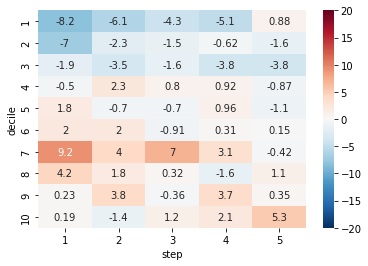

In [38]:
sns.heatmap(ess, vmin=-20, vmax=20, cmap='RdBu_r', annot=True, center=0) 
f = plt.gcf()

In [39]:
f.set_figheight(5)
f.set_figwidth(8)

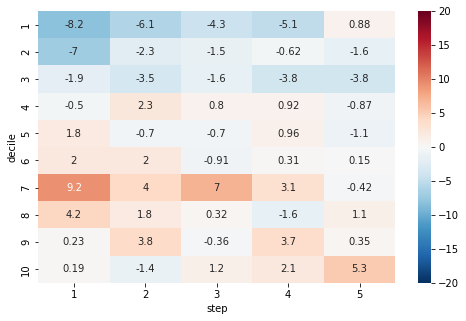

In [40]:
f

In [41]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA', 'ECCC']

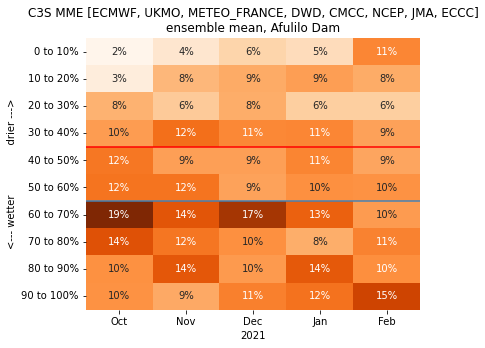

In [44]:
f, ax = plot.plot_heatmap(mat_ensmean, cmap='Oranges_r', title=f'C3S MME [{", ".join(GCMs)}]\nensemble mean, Afulilo Dam', cumsum=False, start_month=month + 1)

In [47]:
f.savefig(f'/home/nicolasf/Desktop/Afulilo_Dam_{period}_{quantile}_probs.png', dpi=200, facecolor='w', bbox_inches='tight')

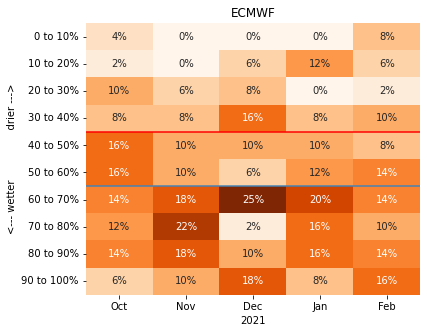

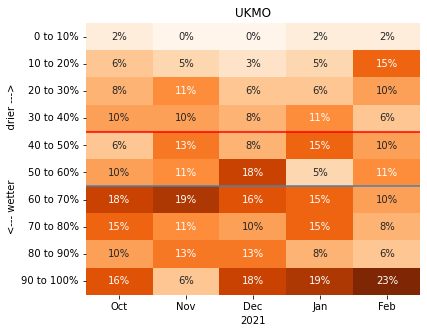

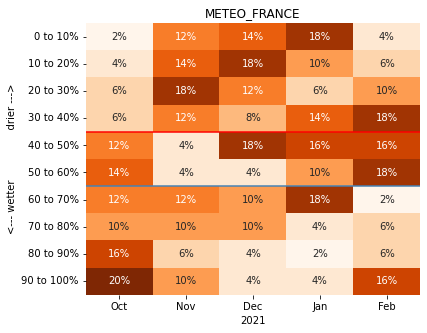

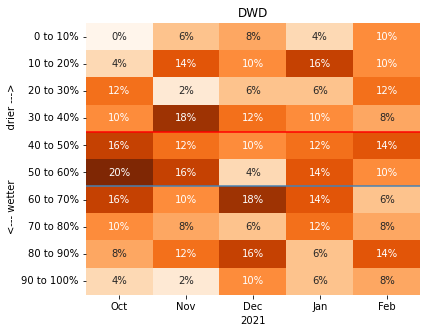

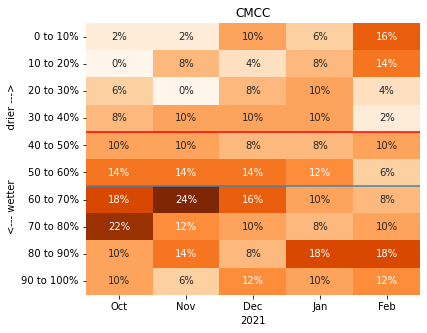

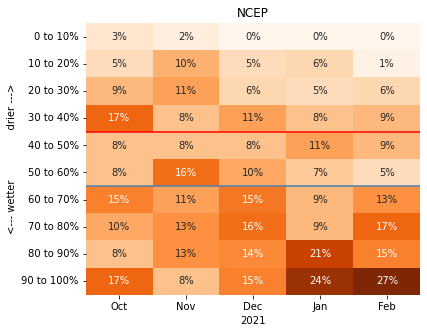

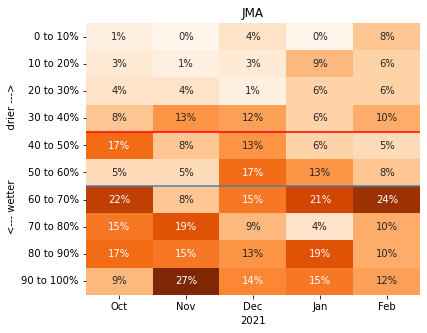

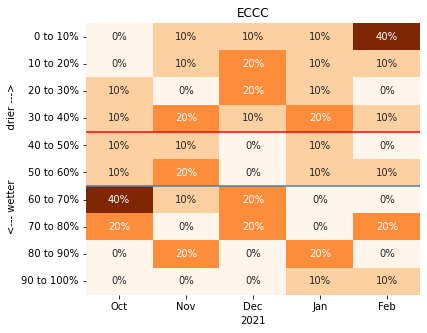

In [43]:
for GCM in GCMs:
    f, ax = plot.plot_heatmap(mat.loc[GCM,:], cmap='Oranges_r', title=GCM, start_month= month + 1, cumsum=False)
    f.savefig(f'./heatmap_{GCM}.png', dpi=200, bbox_inches='tight', facecolor='w')